In [264]:
%pylab inline
# make plot bigger
pylab.rcParams['figure.figsize'] = (15.0, 12.0)

Populating the interactive namespace from numpy and matplotlib


In [271]:
import glob
import os
import platform
import json
import math
from pprint import pprint
from lxml import objectify
from shapely.geometry import Point, LineString
from copy import deepcopy 
from datetime import datetime, timedelta
from operator import itemgetter 

In [272]:
# detect Dropbox path
platform_name = platform.system()
if platform_name == 'Windows':
    # Windows > XP
    dropbox_info_path = "%s\Dropbox\info.json" % os.getenv('APPDATA')
else:
    # Linux/Mac
    dropbox_info_path = "%s/.dropbox/info.json" % os.getenv('HOME')
with open(dropbox_info_path, "r") as f:    
    dropbox_path = json.load(f)['personal']['path']      

print dropbox_path

/Users/tiratatp/Dropbox


In [273]:
def distance(lat1, lat2, lon1, lon2, el1, el2):    
    R = 6371 # Radius of the earth

    latDistance = math.radians(lat2 - lat1)
    lonDistance = math.radians(lon2 - lon1)
    a = math.sin(latDistance / 2) * math.sin(latDistance / 2) \
            + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) \
            * math.sin(lonDistance / 2) * math.sin(lonDistance / 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c * 1000 # convert to meters

    height = el1 - el2
    distance = math.pow(distance, 2) + math.pow(height, 2);
    return math.sqrt(distance)

def distance_trackpoint(t1, t2):
    return distance(t1.Position['LatitudeDegrees'], t2.Position['LatitudeDegrees'], \
                    t1.Position['LongitudeDegrees'], t2.Position['LongitudeDegrees'], \
                    t1.AltitudeMeters, t2.AltitudeMeters)

def point_from_trackpoint(t):
    return Point(t.Position['LatitudeDegrees'], t.Position['LongitudeDegrees'], t.AltitudeMeters)

def time_trackpoint(t1, t2):
    time1 = datetime.strptime(str(t1.Time), "%Y-%m-%dT%H:%M:%S.%fZ")
    time2 = datetime.strptime(str(t2.Time), "%Y-%m-%dT%H:%M:%S.%fZ")
    return (time2 - time1).total_seconds()
        
def split_trackpoints(t1, t2, distance):
    new_length_ratio = float(distance) / distance_trackpoint(t1, t2)
    
    # split distant
    line = LineString([point_from_trackpoint(t1), point_from_trackpoint(t2)])
    mid = deepcopy(t1)
    minpoint = line.interpolate(new_length_ratio, normalized=True)
    mid.Position['LatitudeDegrees'] = minpoint.x
    mid.Position['LongitudeDegrees'] = minpoint.y
    mid.AltitudeMeters = minpoint.z
    
    # split time
    time1 = datetime.strptime(str(t1.Time), "%Y-%m-%dT%H:%M:%S.%fZ")
    midtime = time1 + timedelta(seconds=time_trackpoint(t1, t2) * new_length_ratio)
    mid.Time = midtime.strftime("%Y-%m-%dT%H:%M:%S.%fZ")
    return (t1, mid, t2)

In [275]:
all_tcx = glob.glob(os.path.join(dropbox_path, "Apps", "tapiriik", "*.tcx"))
activities = []
if len(all_tcx) == 0:
    raise IOError("Cannot find tapiriik folder! Visit https://tapiriik.com to set it up.")
for f in all_tcx:
    activity_root = objectify.parse(f).getroot().Activities.Activity    
    activity = {
        'laps': [],
        'type': activity_root.attrib['Sport'].lower(),        
        'start': activity_root.Id,
        'start_datetime': datetime.strptime(str(activity_root.Id), "%Y-%m-%dT%H:%M:%S.%fZ"),
    }   
    for lap in activity_root.Lap:
        current_lap = {
            'segments': [], # 1 km segments
            'maximum_speed': None,
            'calories': lap.Calories,
            'distance_meters': lap.DistanceMeters,
            'total_time_seconds': lap.TotalTimeSeconds,            
        }
        if hasattr(lap, 'MaximumSpeed'):
            current_lap['maximum_speed'] = lap.MaximumSpeed        
        current_segment = {
            'trackpoints': [],
            'distance': 0.0,
            'time': 0.0
        }
        previous_trackpoint = None
        for trackpoint in lap.Track.Trackpoint:
            if not hasattr(trackpoint, 'AltitudeMeters'):
                continue
            if previous_trackpoint is None:
                previous_trackpoint = trackpoint
                continue   
            new_distance = distance_trackpoint(previous_trackpoint, trackpoint)
            if current_segment['distance'] + new_distance > 1000: 
                while current_segment['distance'] + new_distance > 1000:
                    need_distance = 1000 - current_segment['distance']      
                    (previous_trackpoint, mid, trackpoint) = split_trackpoints(previous_trackpoint, trackpoint, need_distance)

                    #current_segment['trackpoints'].append(mid)
                    current_segment['distance'] += distance_trackpoint(previous_trackpoint, mid)
                    current_segment['time'] += time_trackpoint(previous_trackpoint, mid)
                    current_segment['speed'] = current_segment['distance'] / current_segment['time']
                
                    current_lap['segments'].append(current_segment)
                    current_segment = {
                        'trackpoints': [],
                        'distance': 0.0,
                        'time': 0.0
                    }
                    
                    new_distance = distance_trackpoint(mid, trackpoint)
                    previous_trackpoint = mid            
            else:
                #current_segment['trackpoints'].append(trackpoint)
                current_segment['distance'] += new_distance
                current_segment['time'] += time_trackpoint(previous_trackpoint, trackpoint)                                
            previous_trackpoint = trackpoint
        current_lap['average_speed'] = np.mean([s['speed'] for s in current_lap['segments']])
        activity['laps'].append(current_lap)
    activity['maximum_speed'] = max([lap['maximum_speed'] for lap in activity['laps']])
    activity['calories'] = sum([lap['calories'] for lap in activity['laps']])
    activity['distance_meters'] = sum([lap['distance_meters'] for lap in activity['laps']])
    activity['total_time_seconds'] = sum([lap['total_time_seconds'] for lap in activity['laps']])
    activity['average_speed'] = np.mean([lap['average_speed'] for lap in activity['laps']])
    activities.append(activity)

/Users/tiratatp/miniconda/envs/endomondo/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/tiratatp/miniconda/envs/endomondo/lib/python2.7/site-packages/numpy/core/_methods.py:71: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [276]:
pprint(activities, depth=6)

[{'average_speed': 6.3077576560844841,
  'calories': 431,
  'distance_meters': 13735.217094421387,
  'laps': [{'average_speed': 6.3077576560844841,
            'calories': 431,
            'distance_meters': 13735.217094421387,
            'maximum_speed': 11.197222222222223,
            'segments': [{'distance': 999.9999970567183,
                          'speed': 6.325978422205949,
                          'time': 158.078313,
                          'trackpoints': []},
                         {'distance': 1000.0000044086265,
                          'speed': 6.935075861814083,
                          'time': 144.19453,
                          'trackpoints': []},
                         {'distance': 1000.0012748425772,
                          'speed': 7.279317311862023,
                          'time': 137.375695,
                          'trackpoints': []},
                         {'distance': 1000.0000140634038,
                          'speed': 7.061554689112721,
 

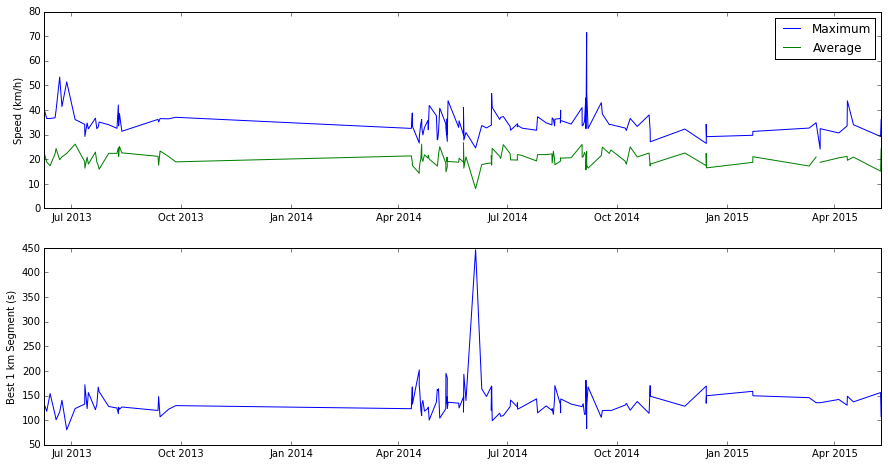

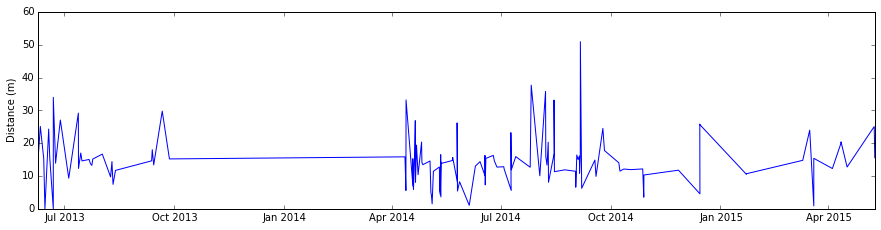

In [277]:
x = []
y1 = []
y2 = []

for a in activities:
    if a['type'] != 'biking':
        continue
    if a['maximum_speed'] is not None:
        x.append(a['start_datetime'])
        y1.append(a['maximum_speed'] * 3.6)
        y2.append(a['average_speed'] * 3.6)

fig = plt.figure()
ax1 = fig.add_subplot(311)
ax1.plot(x,y1, label='Maximum')
ax1.plot(x,y2, label='Average')
ax1.set_ylabel('Speed (km/h)')    
plt.legend(loc=0)

x = []
y = []
for a in activities:
    if a['type'] != 'biking':
        continue
    fastest = None
    for l in a['laps']:
        for s in l['segments']:
            if fastest is None:
                fastest = s['time']
            elif fastest > s['time']:
                fastest = s['time']
    if fastest is not None:
        x.append(a['start_datetime'])
        #y.append(timedelta(seconds=fastest))
        y.append(fastest)
            
ax2 = fig.add_subplot(312)
# uncomment this to set ymin to 0
#ax2.set_ylim(bottom=0)
ax2.plot(x,y)
ax2.set_ylabel('Best 1 km Segment (s)')   

x = []
y = []
for a in activities:
    if a['type'] != 'biking':
        continue
    if a['distance_meters'] is not None:
        x.append(a['start_datetime'])
        y.append(a['distance_meters'] / 1000.0)
fig = plt.figure()
ax3 = fig.add_subplot(313)
ax3.plot(x,y)
ax3.set_ylabel('Distance (m)')    
plt.legend(loc=0)

plt.show()    